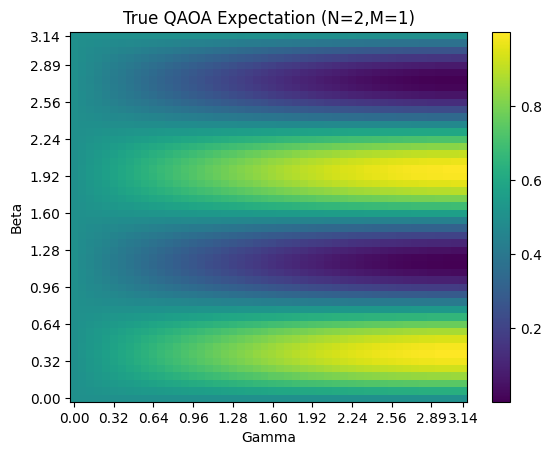

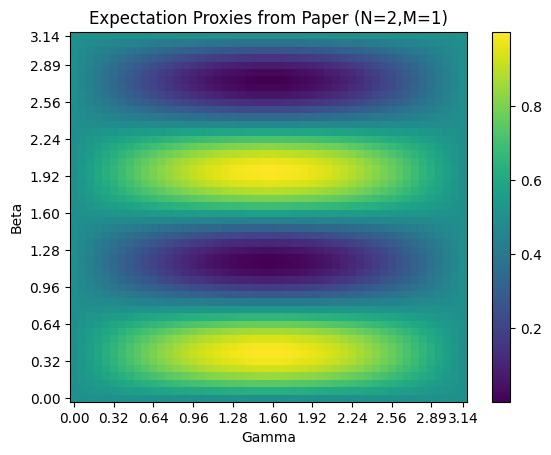

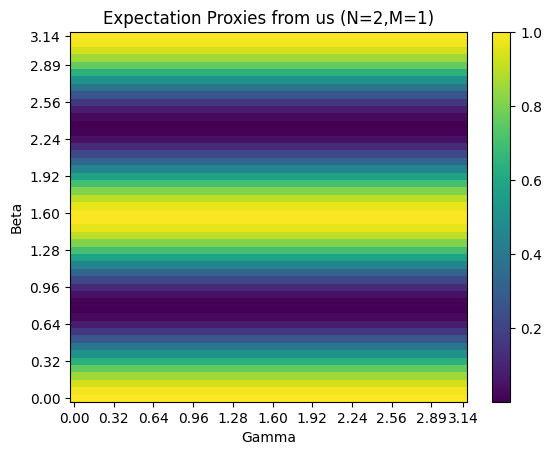

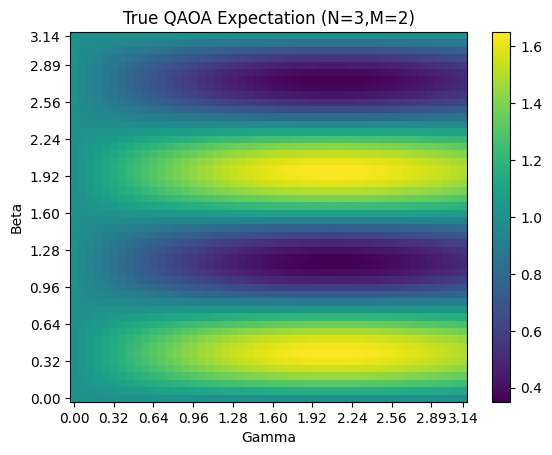

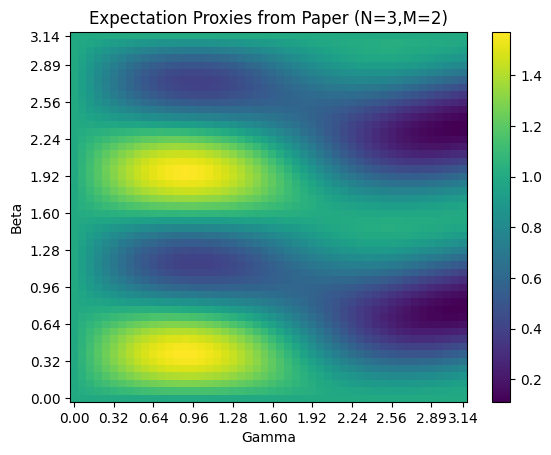

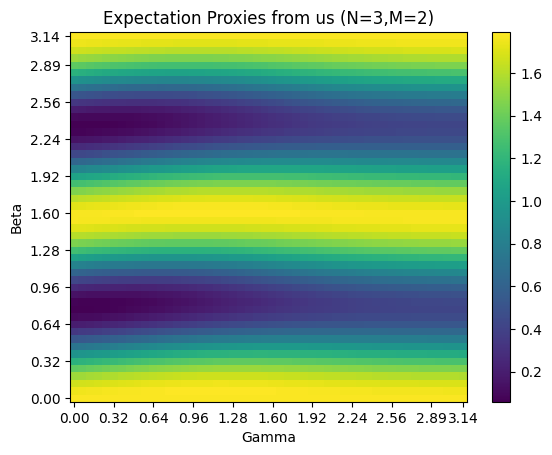

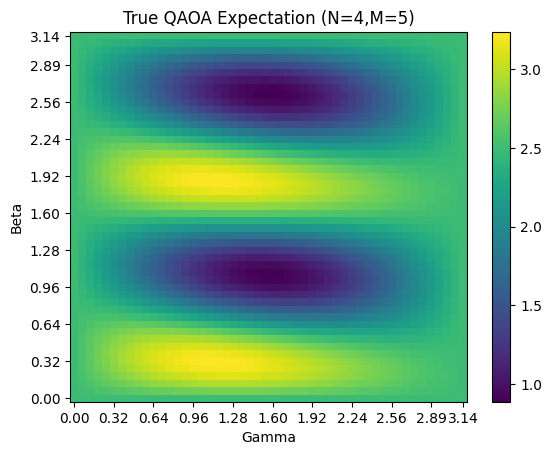

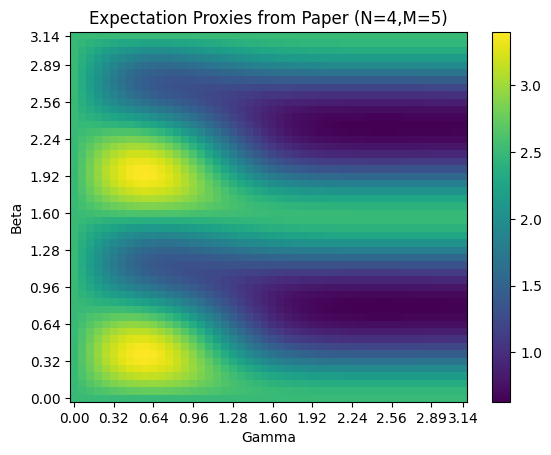

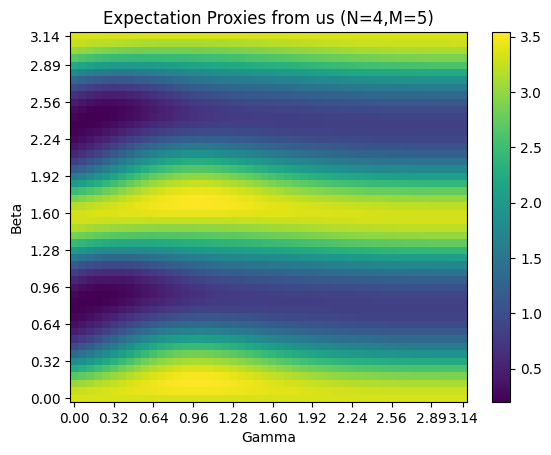

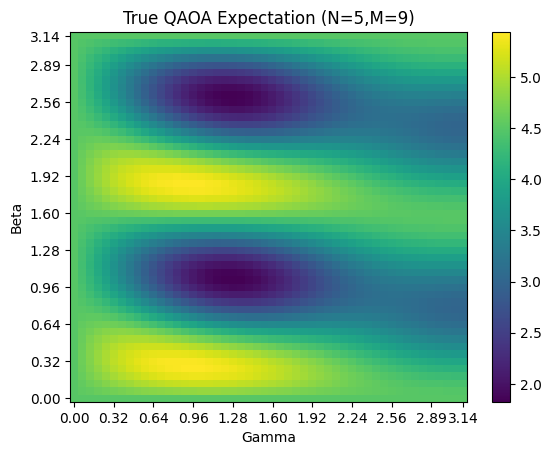

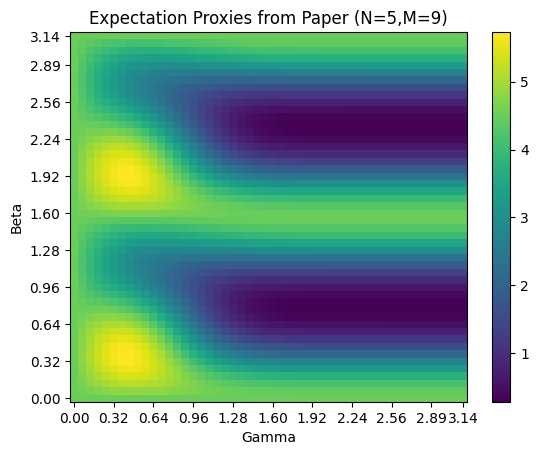

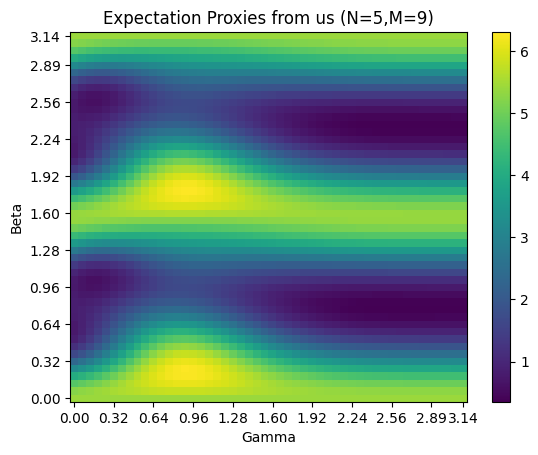

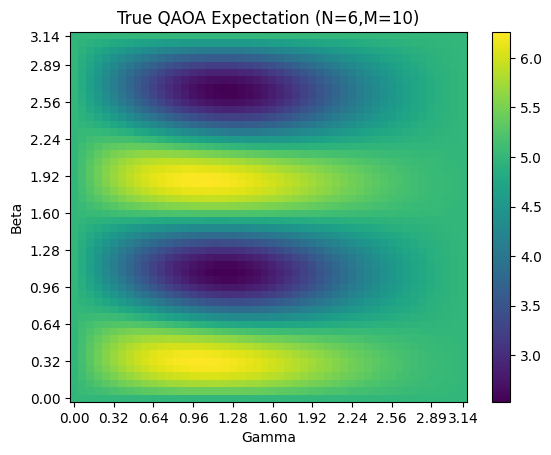

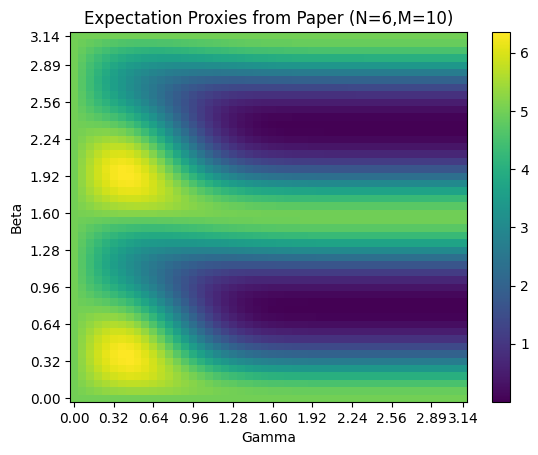

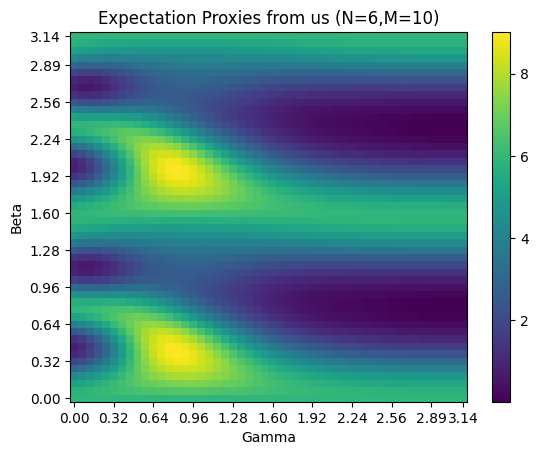

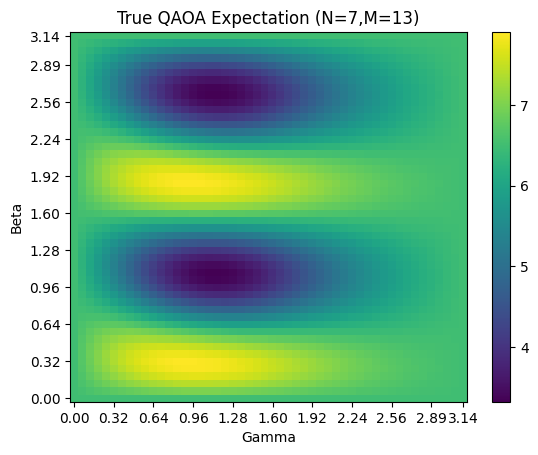

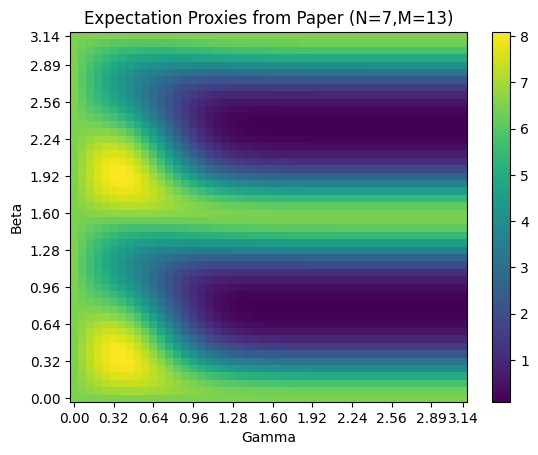

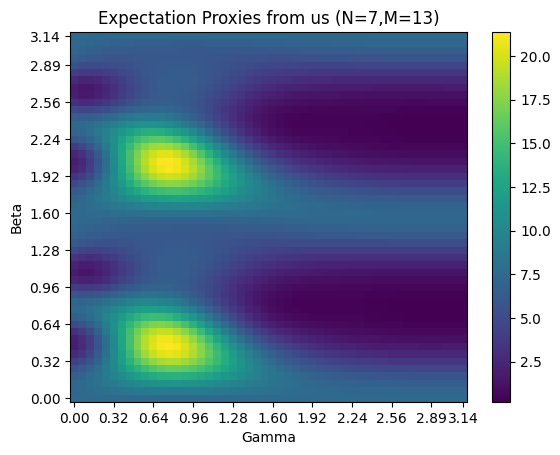

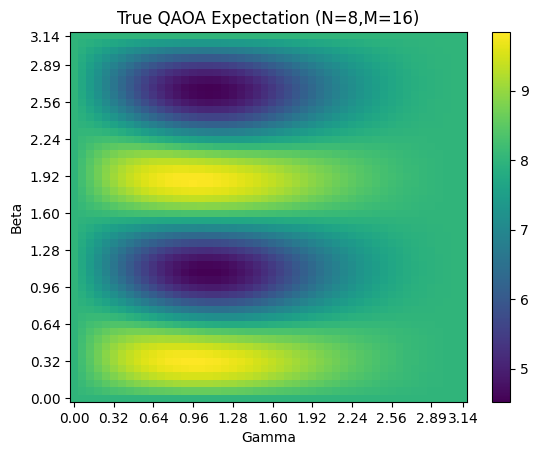

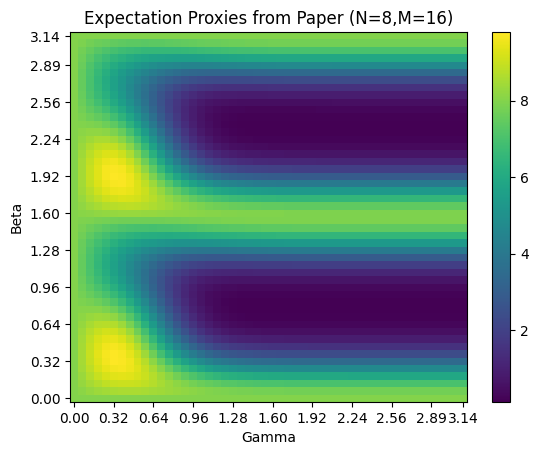

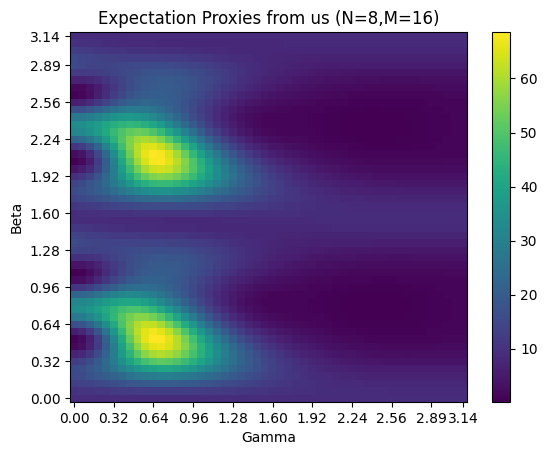

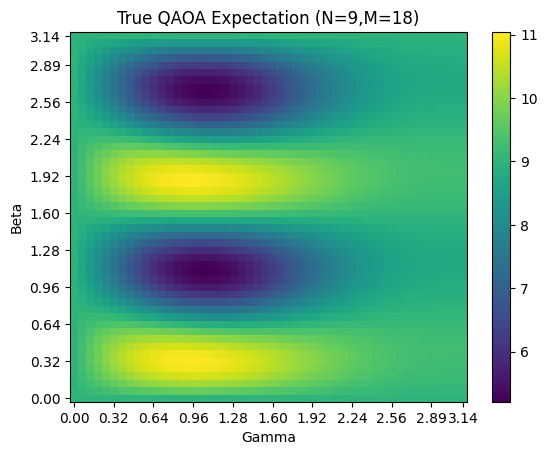

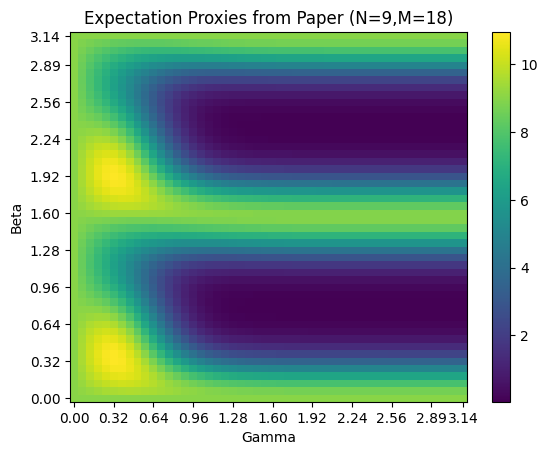

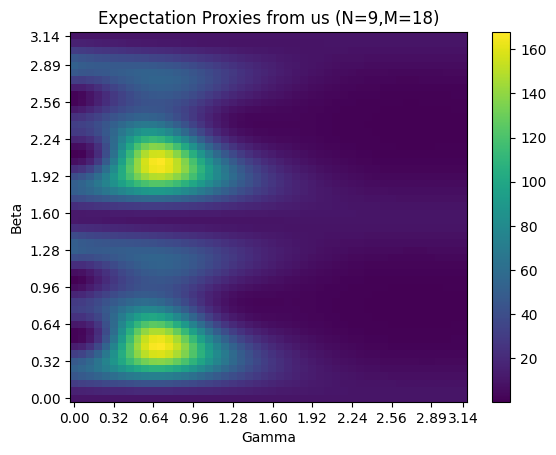

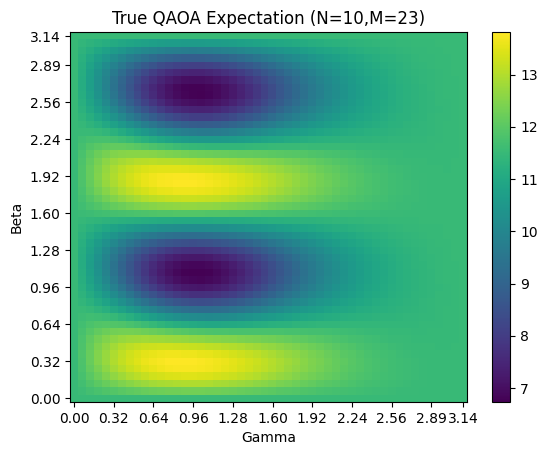

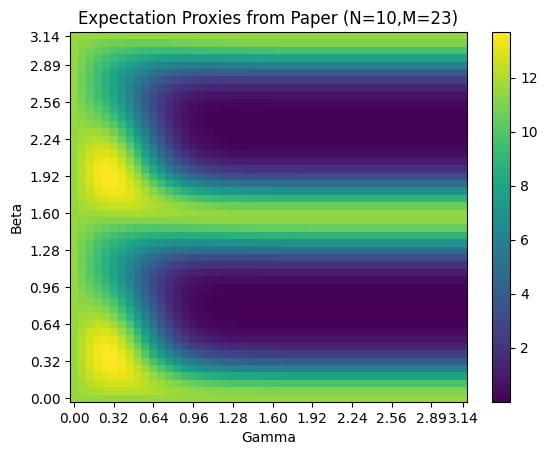

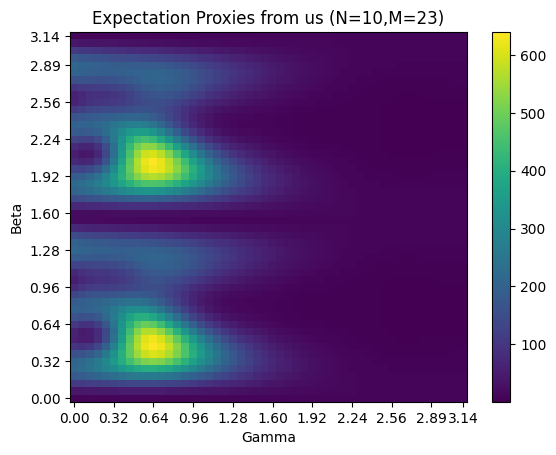

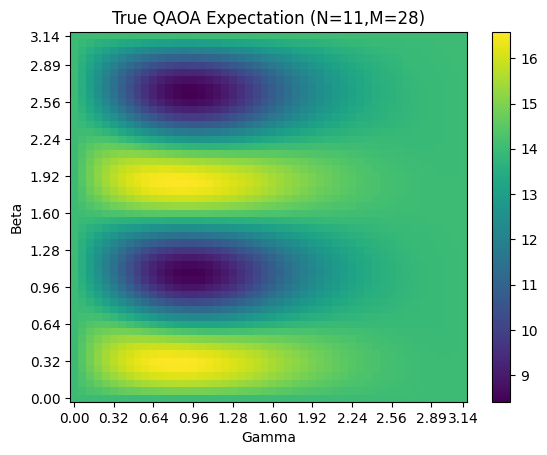

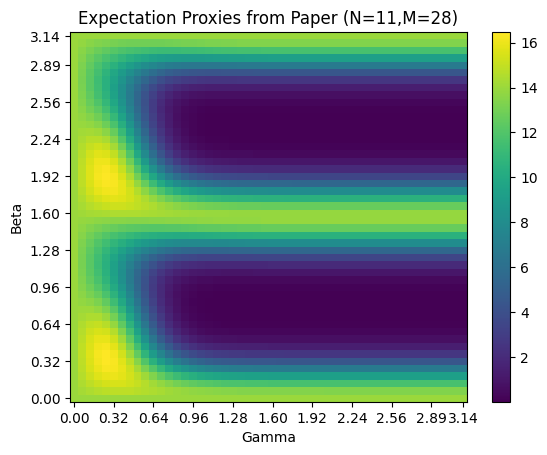

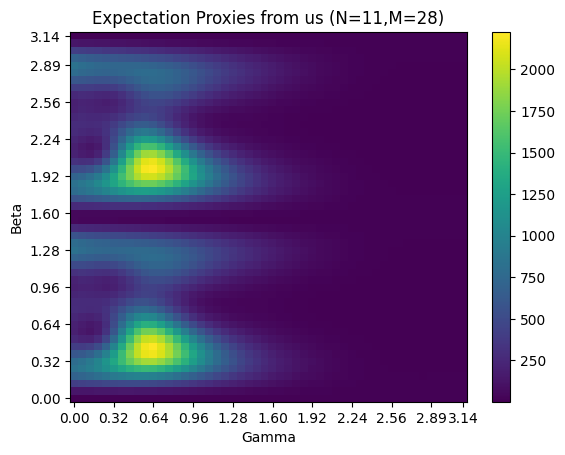

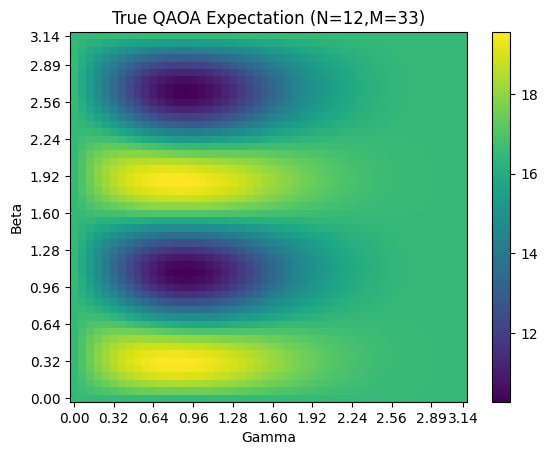

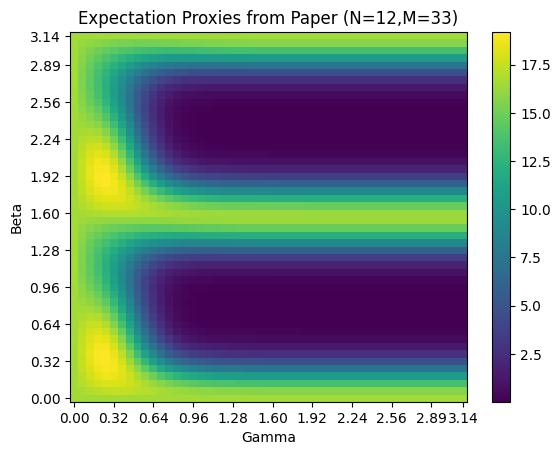

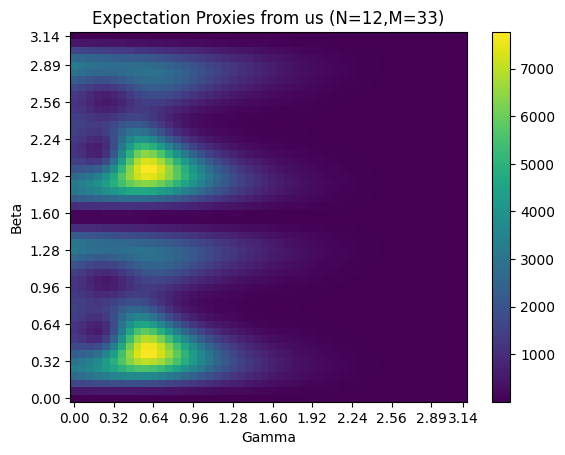

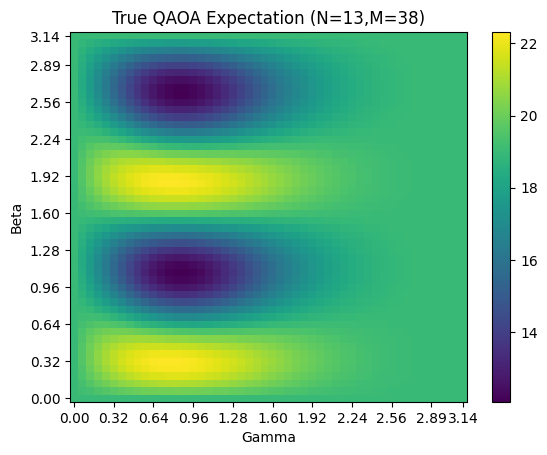

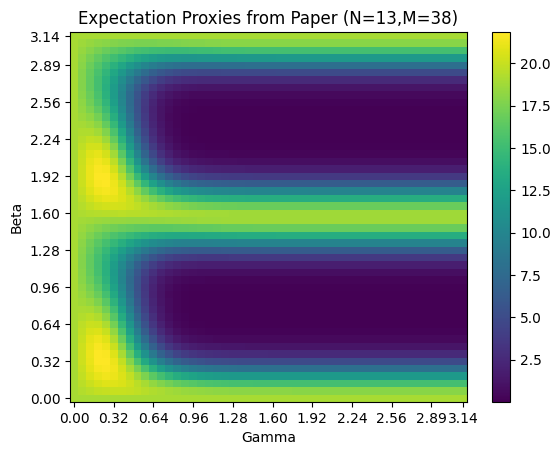

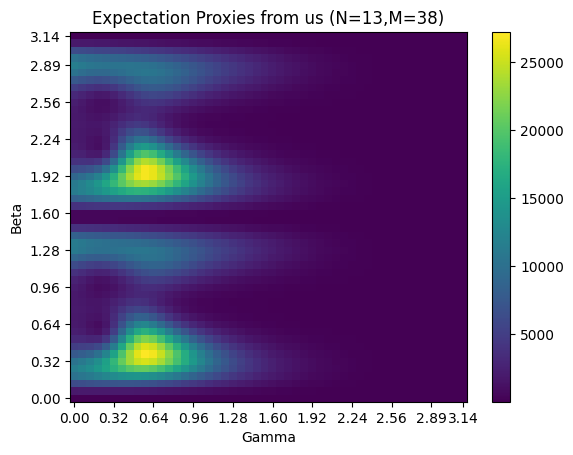

In [6]:
import os
import matplotlib.pyplot as plt
import networkx as nx
import qokit.maxcut as mc
import numpy as np
from QAOA_proxy import QAOA_proxy
from QAOA_paper_proxy import QAOA_paper_proxy
from QAOA_simulator import get_simulator, get_expectation, get_result
from plot_utils import plot_heat_map

def collect_parameter_data(G: nx.Graph, gammas: np.ndarray, betas: np.ndarray) -> np.ndarray:
    expectations = np.zeros([len(gammas), len(betas)])
    N = G.number_of_nodes()
    ising_model = mc.get_maxcut_terms(G)
    sim = get_simulator(N, ising_model)

    for i in range(len(gammas)):
        for j in range(len(betas)):
            gamma = np.array([gammas[i]])
            beta = np.array([betas[j]])
            result = get_result(N, ising_model, gamma, beta, sim)
            expectations[i][j] = get_expectation(N, ising_model, gamma, beta, sim, result)

    return expectations


def collect_parameter_data_proxy_less_dumb(num_constraints: int, num_qubits: int, gammas: np.ndarray, betas: np.ndarray) -> np.ndarray:
    expectations = np.zeros([len(gammas), len(betas)])

    for i in range(len(gammas)):
        for j in range(len(betas)):
            gamma = np.array([gammas[i]])
            beta = np.array([betas[j]])
            _, expectations[i][j] = QAOA_proxy(1, gamma, beta, num_constraints, num_qubits)

    return expectations


def collect_parameter_data_proxy(num_constraints: int, num_qubits: int, gammas: np.ndarray, betas: np.ndarray) -> np.ndarray:
    expectations = np.zeros([len(gammas), len(betas)])

    for i in range(len(gammas)):
        for j in range(len(betas)):
            gamma = np.array([gammas[i]])
            beta = np.array([betas[j]])
            _, expectations[i][j] = QAOA_paper_proxy(1, gamma, beta, num_constraints, num_qubits)

    return expectations

# Define parameter ranges
gammas = np.linspace(0, np.pi, 50)
betas = np.linspace(0, np.pi, 50)

for N in range(2, 21):
    G = nx.erdos_renyi_graph(N, 0.5, seed=18)
    M = G.number_of_edges()

    qaoa_path = f"data_for_Expectation_Heatmap/QAOA_N={N}_M={M}.npz"
    paper_proxy_path = f"data_for_Expectation_Heatmap/Paper_Proxy_N={N}_M={M}.npz"
    our_proxy_path = f"data_for_Expectation_Heatmap/Our_Proxy_N={N}_M={M}.npz"

    if os.path.exists(qaoa_path):
        data = np.load(qaoa_path)
        expectations = data['expectations']
        gammas = data['gammas']
        betas = data['betas']
    else:
        expectations = collect_parameter_data(G, gammas, betas)
        np.savez(qaoa_path, expectations=expectations, gammas=gammas, betas=betas)

    if os.path.exists(paper_proxy_path):
        data = np.load(paper_proxy_path)
        expectation_proxies = data['expectations']
        gammas = data['gammas']
        betas = data['betas']
    else:
        expectation_proxies = collect_parameter_data_proxy(M, N, gammas, betas)
        np.savez(paper_proxy_path, expectations=expectation_proxies, gammas=gammas, betas=betas)

    if os.path.exists(our_proxy_path):
        data = np.load(our_proxy_path)
        expectation_proxies_less_dumb = data['expectations']
        gammas = data['gammas']
        betas = data['betas']
    else:
        expectation_proxies_less_dumb = collect_parameter_data_proxy_less_dumb(M, N, gammas, betas)
        np.savez(our_proxy_path, expectations=expectation_proxies_less_dumb, gammas=gammas, betas=betas)

    # Generate and save heatmaps
    _ = plot_heat_map(gammas, betas, expectations, f"True QAOA Expectation (N={N},M={M})", "Gamma", "Beta")
    plt.savefig(f"Expectation_Heatmaps/proxies_0_to_π/QAOA_N={N}_M={M}.png")
    _ = plot_heat_map(gammas, betas, expectation_proxies, f"Expectation Proxies from Paper (N={N},M={M})", "Gamma", "Beta")
    plt.savefig(f"Expectation_Heatmaps/proxies_0_to_π/paper_ploxy_N={N}_M={M}.png")
    _ = plot_heat_map(gammas, betas, expectation_proxies_less_dumb, f"Expectation Proxies from us (N={N},M={M})", "Gamma", "Beta")
    plt.savefig(f"Expectation_Heatmaps/proxies_0_to_π/our_proxy_N={N}_M={M}.png")

    plt.show()

In [ ]:
from QAOA_paper_proxy import QAOA_paper_proxy
from plot_utils import plot_heat_map
import matplotlib.pyplot as plt
import numpy as np

"""
Paper proxy only
"""

def collect_parameter_data(num_constraints: int, num_qubits: int, gammas: np.ndarray, betas: np.ndarray) -> np:
    expectations = np.zeros([len(gammas), len(betas)])

    for i in range(len(gammas)):
        for j in range(len(betas)):
            gamma = np.array([gammas[i]])
            beta = np.array([betas[j]])
            _, expectations[i][j] = QAOA_paper_proxy(1, gamma, beta, num_constraints, num_qubits)

    return expectations

gammas = np.linspace(-np.pi, np.pi, 50)
betas = np.linspace(-2 * np.pi, 2 * np.pi, 50)

# Run experiments for each N
for n in range(2, 16):
    m = int(n * (n - 1) / 4)
    if m < n:
        m = n
    expectations = collect_parameter_data(m, n, gammas, betas)
    plot_heat_map(gammas, betas, expectations, f"Expectation Proxy from paper (N={n} M={m})", "Gamma", "Beta")
    plt.show()

    # Save data
    np.save(f"data_for_Expectation_Heatmap/Paper_Proxy_N={n}_M={m}.npy", expectations)

In [ ]:
from QAOA_proxy import QAOA_proxy, QAOA_proxy_run
from plot_utils import plot_heat_map
import matplotlib.pyplot as plt
import numpy as np

"""
Our proxy only
"""

def collect_parameter_data(num_constraints: int, num_qubits: int, gammas: np.ndarray, betas: np.ndarray) -> np:
    expectations = np.zeros([len(gammas), len(betas)])

    for i in range(len(gammas)):
        for j in range(len(betas)):
            gamma = np.array([gammas[i]])
            beta = np.array([betas[j]])
            _, expectations[i][j] = QAOA_proxy(1, gamma, beta, num_constraints, num_qubits)

    return expectations

gammas = np.linspace(-np.pi, np.pi, 50)
betas = np.linspace(-2 * np.pi, 2 * np.pi, 50)

# Run experiments for each N
for n in range(5, 16):
    m = int(n * (n - 1) / 4)
    if m < n:
        m = n
    expectations = collect_parameter_data(m, n, gammas, betas)
    plot_heat_map(gammas, betas, expectations, f"Expectation Proxy from us (N={n} M={m})", "Gamma", "Beta")
    plt.show()

    result = QAOA_proxy_run(m, n, 1, np.array([0.01]), np.array([0.01]))
    print(result)

    # Save data
    np.save(f"data_for_Expectation_Heatmap/Our_Proxy_N={n}_M={m}.npy", expectations)
